# Predict Future Stock Prices or Sensor Data (Time Series Forecasting) Story

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[['Close']]

# Normalize prices for better training
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ================================
# 🧮 3. Create lagged sequences
# ================================
def create_lagged_features(series, window=10):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_lagged_features(data_scaled, window_size)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

C:\Users\bbuser\AppData\Local\Temp\ipykernel_8176\3138015102.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [3]:
data

Price,Close
Ticker,AAPL
Date,
2020-01-02,72.538513
2020-01-03,71.833290
2020-01-06,72.405663
2020-01-07,72.065140
2020-01-08,73.224396
...,...
2024-12-23,254.367020
2024-12-24,257.286652


In [4]:
# 🔄 4. Prepare data for each model
# ================================
# FFNN expects 2D input
X_train_ffnn = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_ffnn  = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# RNNs (LSTM/GRU) expect 3D input
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Feedforward Neural Network


In [5]:
ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(32, activation='relu'),
    Dense(1)
])
ffnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("Training Feedforward NN...")
ffnn.fit(X_train_ffnn, y_train, validation_data=(X_test_ffnn, y_test),
         epochs=50, batch_size=32, verbose=1)

C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Feedforward NN...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - val_loss: 0.0029
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 9.0579e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6356e-04 - val_loss: 5.9611e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8175e-04 - val_loss: 7.5198e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5217e-04 - val_loss: 6.4903e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1927e-04 - val_loss: 6.0166e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9790e-04 - val_loss: 4.1413e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0607e-04 - val_loss: 3.8008e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7371e-04 - val_loss: 4.0835e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6234e-04 - val_loss: 3.6911e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.56

### LSTM Model

In [6]:
lstm = Sequential([
    LSTM(64, input_shape=(window_size, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("Training LSTM...")
lstm.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test),
         epochs=50, batch_size=32, verbose=1)

Training LSTM...
Epoch 1/50


C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0414 - val_loss: 0.0305
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0105
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 9.2504e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 8.7746e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 9.5017e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.

### GRU Model

In [7]:
gru = Sequential([
    GRU(64, input_shape=(window_size, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("Training GRU...")
gru.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test),
        epochs=50, batch_size=32, verbose=1)

Training GRU...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0404 - val_loss: 0.0272
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8408e-04 - val_loss: 0.0015
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11

### Plot Predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


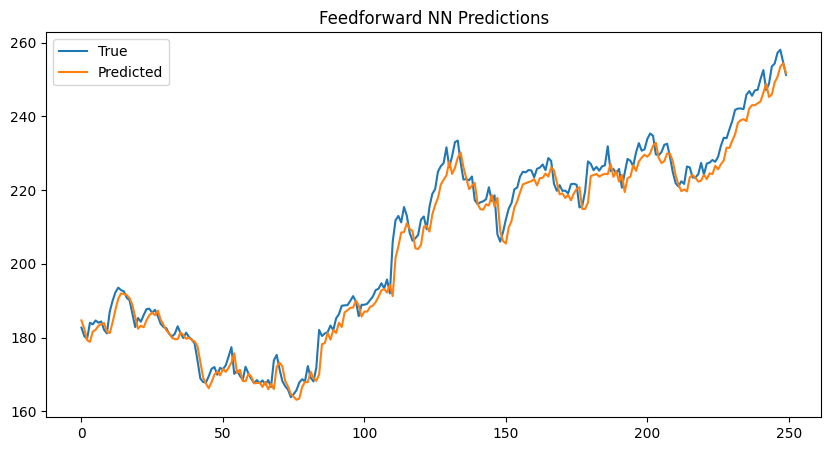

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


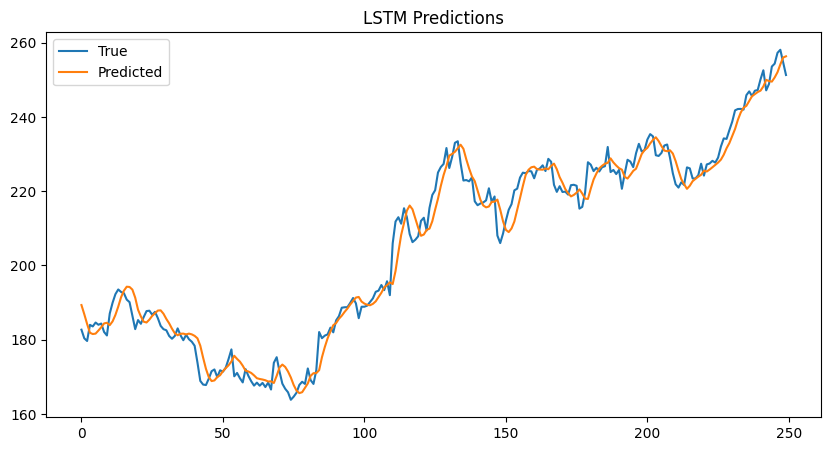

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


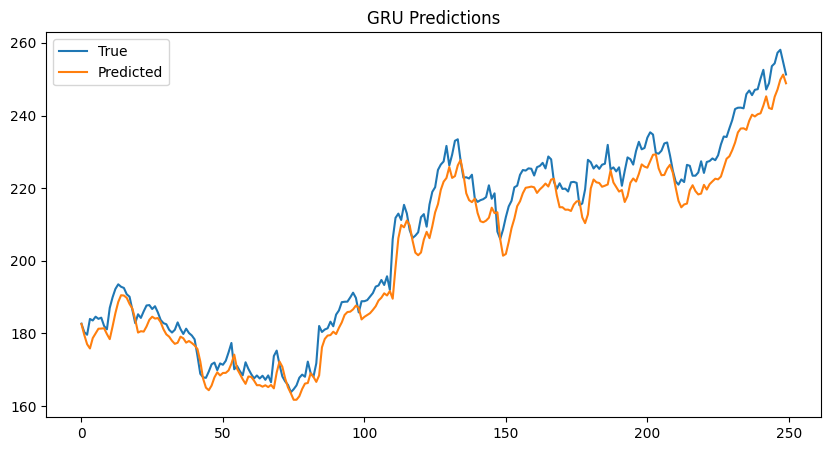

In [8]:
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_rescaled, label='True')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_predictions(ffnn, X_test_ffnn, y_test, "Feedforward NN Predictions")
plot_predictions(lstm, X_test_rnn, y_test, "LSTM Predictions")
plot_predictions(gru, X_test_rnn, y_test, "GRU Predictions")

### Compare final MSE

In [9]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

mse_ffnn = evaluate_model(ffnn, X_test_ffnn, y_test)
mse_lstm = evaluate_model(lstm, X_test_rnn, y_test)
mse_gru  = evaluate_model(gru, X_test_rnn, y_test)

print("\n🔍 Model Comparison:")
print(f"Feedforward NN MSE: {mse_ffnn:.6f}")
print(f"LSTM          MSE: {mse_lstm:.6f}")
print(f"GRU           MSE: {mse_gru:.6f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

🔍 Model Comparison:
Feedforward NN MSE: 0.000338
LSTM          MSE: 0.000362
GRU           MSE: 0.000789
